# Task VIII: Vision transformer/Quantum Vision Transformer
Implement a classical Vision transformer and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail.


---



---



##  Classical Vision Transformer on MNIST

The Vision Transformer (ViT) is a deep learning model that applies the Transformer architecture, originally designed for NLP tasks, to computer vision. Instead of using convolutional layers like in traditional CNNs, ViT treats an image as a sequence of patches and processes it similarly to a sequence of words in a sentence.

###  Objective:
We will implement a simplified **Vision Transformer (ViT)** and apply it to the **MNIST dataset**, which contains 70,000 grayscale images of handwritten digits (0–9), each of size 28×28 pixels.

###  What we will do:
- Split each MNIST image into **small non-overlapping patches** (e.g., 7×7 patches).
- Flatten and embed each patch into a vector space.
- Add **positional encodings** to maintain spatial information.
- Feed the sequence of embedded patches into a **Transformer encoder**.
- Use the output to classify the digit.

This approach allows us to explore how powerful the Transformer architecture can be in vision tasks, even without convolutions.





---



---



## Step 1: Install and Import Required Libraries

We begin by installing necessary libraries and importing relevant modules:

- `torch`, `torchvision`: Core PyTorch framework and datasets.
- `einops`: Handy for rearranging tensors (used for patch flattening).
- `matplotlib`: For visualizing results.

`einops` is particularly useful for handling the patching operation required in Vision Transformers.


In [1]:
!pip install torchvision einops --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from einops import rearrange
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.0 MB/s eta 0:00:00


## Step 2: Load and Prepare the MNIST Dataset

We load the classic MNIST dataset using `torchvision.datasets`. Each image is:

- Grayscale (1×28×28),
- Normalized to the range [0, 1],
- Converted to a PyTorch tensor.

We use `DataLoader` to enable batch processing for both training and testing.


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


100%|██████████| 9.91M/9.91M [00:00<00:00, 56.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.33MB/s]


## Step 3: Define the Vision Transformer (ViT) Architecture

This class implements a simplified Vision Transformer (ViT) model with the following components:

- **Patch Embedding**: Flattens the image into small patches (e.g., 7×7) and projects them into a high-dimensional space.
- **Positional Encoding**: Adds learnable position embeddings to preserve spatial information lost during patching.
- **[CLS] Token**: A special classification token prepended to the patch sequence; the output of this token is used for classification.
- **Transformer Encoder**: Applies multiple layers of self-attention and feed-forward networks to model global dependencies.
- **MLP Head**: The output from the [CLS] token is passed through a fully connected layer to predict one of the 10 MNIST digits.

This architecture allows the model to process the image as a sequence of patches — similar to how transformers process words in NLP.


In [3]:
class ViT(nn.Module):
    def __init__(self, image_size=28, patch_size=7, num_classes=10, dim=64, depth=4, heads=4, mlp_dim=128):
        super().__init__()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = patch_size * patch_size

        self.patch_size = patch_size
        self.patch_embedding = nn.Linear(patch_dim, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        # x shape: [batch, 1, 28, 28]
        b, c, h, w = x.shape
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2)', p1=self.patch_size, p2=self.patch_size)

        x = self.patch_embedding(x)  # [b, num_patches, dim]
        b, n, _ = x.shape

        cls_tokens = self.cls_token.expand(b, -1, -1)  # [b, 1, dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [b, 1 + num_patches, dim]
        x += self.pos_embedding[:, :(n)]

        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])  # take cls token output

        return self.mlp_head(x)


## Vision Transformer (ViT) on MNIST – Training Pipeline

In this section, we implement and train a **simplified Vision Transformer (ViT)** model on the MNIST dataset. Here's a breakdown of each component:

---

### Dataset & DataLoader

We load the **MNIST dataset** using `torchvision.datasets.MNIST` with simple tensor transformation and create `DataLoader`s for training and testing.

- **Batch size**: 128
- **Image size**: 28x28 grayscale images
- **Dataset**: Digits (0–9), 60,000 training and 10,000 test samples

---

### Patch Embedding Layer

We divide each image into **non-overlapping patches** using a `Conv2D` layer:
- **Patch size**: 7×7
- **Embedding dimension**: 32
- Each 28×28 image becomes 16 patches (4×4), flattened and linearly embedded.
- A learnable **class token** and **positional embeddings** are added to form the input sequence for the Transformer.

---

### Transformer Encoder

We use a basic Transformer encoder:
- **2 layers**
- **2 attention heads**
- `nn.TransformerEncoderLayer` is wrapped into a `nn.TransformerEncoder`

This allows the model to attend to the global context of the image patches.

---

### MLP Head

After encoding, we extract the representation corresponding to the **class token** and pass it through a small MLP:
- `LayerNorm`
- `Linear` layer projecting to `10` output classes (for MNIST digits)

---

### Training Loop

We train the model using:
- **Loss function**: CrossEntropyLoss
- **Optimizer**: Adam with learning rate `1e-3`
- **Epochs**: 5

Each epoch prints the average training loss to monitor convergence.

---

This completes the end-to-end training of a minimal Vision Transformer model on MNIST. Next, we can evaluate its performance, plot confusion matrices, and explore extensions to a **Quantum Vision Transformer (QViT)**.


In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=7, emb_size=32, img_size=28):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches + 1, emb_size))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        return x + self.pos_embedding

# Transformer Encoder
class SimpleTransformer(nn.Module):
    def __init__(self, emb_size=32, heads=2, layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=layers)

    def forward(self, x):
        return self.transformer(x)

# ViT Model
class VisionTransformer(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.embed = PatchEmbedding()
        self.encoder = SimpleTransformer()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(32),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        return self.mlp_head(x[:, 0])

# Model, Loss, Optimizer
model = VisionTransformer().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"[{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}")


[1/5] Loss: 1.0566
[2/5] Loss: 0.3386
[3/5] Loss: 0.2449
[4/5] Loss: 0.2019
[5/5] Loss: 0.1763


In [9]:
# Evaluation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")


✅ Test Accuracy: 96.89%


###  Confusion Matrix

To better understand the performance of our Vision Transformer, we plot a confusion matrix. This matrix shows how often actual digits (0-9) were classified correctly or confused with other digits.

- Diagonal elements: Correct classifications.
- Off-diagonal elements: Misclassifications.

A perfect model would show a diagonal-only matrix.

This visualization helps pinpoint which digits are more prone to being misclassified.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


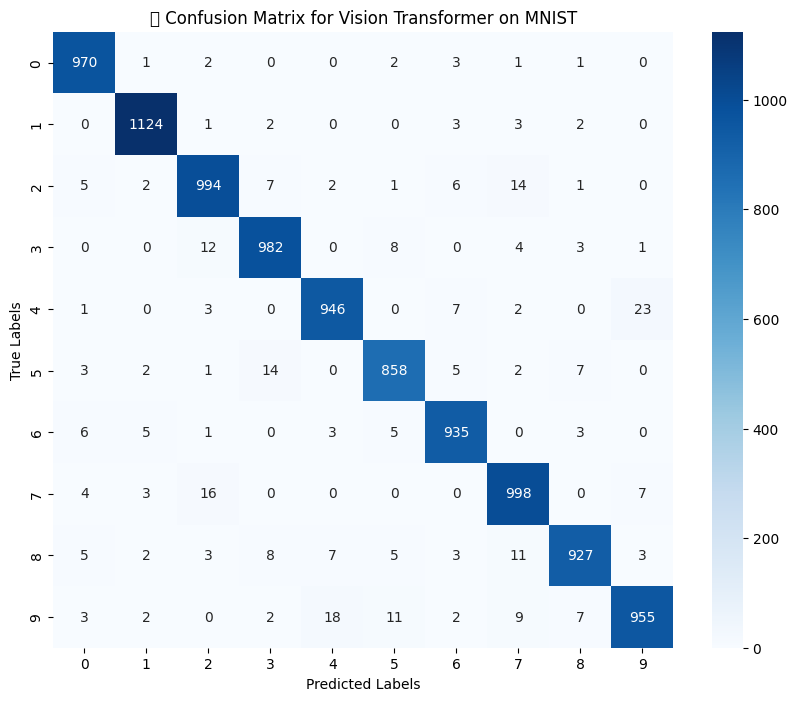

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("📊 Confusion Matrix for Vision Transformer on MNIST")
plt.show()




---



---



## Quantum Vision Transformer (QViT) – Design & Motivation

While classical Vision Transformers (ViTs) utilize linear projections and self-attention mechanisms, the Quantum Vision Transformer (QViT) introduces quantum circuits as a way to encode and process image patches.

### Key Differences from Classical ViT
- **Patch Encoding**: Classical ViT uses convolutional layers to embed patches. In QViT, quantum circuits (parameterized by trainable angles) embed classical data into quantum states.
- **Quantum Layer Integration**: A quantum circuit replaces part of the MLP or transformer block in the ViT architecture to perform feature transformation.
- **Potential Benefits**: Due to quantum superposition and entanglement, QViTs might offer more expressive representations on fewer parameters for certain data regimes.

###  Architecture Overview
1. **Patch Extraction**: Same as classical ViT (split 28x28 into non-overlapping 7x7 patches).
2. **Patch Encoding via Quantum Circuit**: Each patch is passed through a parameterized quantum circuit.
3. **Transformer Encoder**: The quantum-enhanced patch embeddings are passed to a lightweight transformer encoder.
4. **Classification Head**: Final class prediction is made using a dense layer on the `[CLS]` token.

We'll now define the quantum circuit and embed it within a ViT-like architecture.




---



---



# Since a full QViT is an emerging concept and often requires hybrid classical-quantum models, we’ll follow a reasonable and illustrative path:
We'll:
1.  Use a simplified classical ViT for patch embedding.
2.   Replace the transformer encoder with a quantum circuit-based layer.
3.   Feed the quantum outputs into a classifier.






In [12]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 94.4 MB/s eta 0:00:00


In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import pennylane as qml
from pennylane import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data Loading (reuse MNIST loader)

In [14]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Patch Embedding (same as classical ViT)

We divide the image into patches and convert them into embedding vectors. These embeddings are then fed into the quantum layer.

In [15]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=7, emb_size=4, img_size=28):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, emb_size, 4, 4]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, emb_size]
        return x


# Define Quantum Circuit Layer

###  Quantum Circuit Definition

This cell defines the parameterized quantum circuit using PennyLane. It:
- Encodes inputs with `RY` rotations.
- Applies entanglement in a ring topology.
- Uses `RY` variational gates with learnable weights.
- Measures expectation values of Pauli-Z for each qubit.


In [34]:
import pennylane as qml

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Embed input
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Variational layers
    for l in range(weights.shape[0]):
        for i in range(n_qubits):
            qml.RX(weights[l, i, 0], wires=i)
            qml.RY(weights[l, i, 1], wires=i)
            qml.RZ(weights[l, i, 2], wires=i)

        # Entanglement (simple linear entanglement)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

    # Return Z expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


#Create a Quantum Layer Module for PyTorch
This layer will allow us to treat our quantum circuit just like any other layer in a neural network.

In [35]:
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits=4, n_layers=1):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        # Initialize trainable quantum parameters (1 layer × n_qubits × 3 angles)
        self.params = nn.Parameter(0.01 * torch.randn(n_layers, n_qubits, 3))

    def forward(self, x):
        x_quantum = []
        for i in range(x.shape[0]):
            q_out = quantum_circuit(x[i], self.params)
            q_tensor = torch.tensor(q_out, dtype=torch.float32)
            x_quantum.append(q_tensor)
        return torch.stack(x_quantum)


# Test: QuantumLayer with Dummy Input

Here’s a quick script to verify that the QuantumLayer works on a batch of inputs:

In [36]:
# Dummy input with 8 samples, 4 features each (e.g., flattened patch embeddings)
dummy_input = torch.rand((8, 4), dtype=torch.float32)

# Instantiate quantum layer
q_layer = QuantumLayer()

# Forward pass
output = q_layer(dummy_input)

print("Quantum Layer Output Shape:", output.shape)
print("Quantum Layer Output:", output)


Quantum Layer Output Shape: torch.Size([8, 4])
Quantum Layer Output: tensor([[0.9987, 0.5645, 0.5611, 0.4247],
        [0.9959, 0.9658, 0.9200, 0.5809],
        [0.8499, 0.6355, 0.4506, 0.3585],
        [0.9979, 0.6661, 0.6617, 0.5851],
        [0.6061, 0.5199, 0.5194, 0.4663],
        [0.8601, 0.7699, 0.6724, 0.5061],
        [0.9930, 0.9919, 0.5879, 0.3473],
        [0.9247, 0.9190, 0.9077, 0.5235]])


# Hybrid QViT Model

In [37]:
class HybridQViT(nn.Module):
    def __init__(self, num_classes=10, emb_size=32, quantum_output_dim=2):
        super(HybridQViT, self).__init__()
        self.embedding = PatchEmbedding(emb_size=emb_size)
        self.encoder = SimpleTransformer(emb_size=emb_size)

        # Quantum layer expects small input, so we reduce embedding dimension before quantum circuit
        self.to_quantum_input = nn.Linear(emb_size, quantum_output_dim)
        self.quantum_layer = QuantumLayer(n_qubits=quantum_output_dim)

        # Final classification layer from quantum output to logits
        self.classifier = nn.Sequential(
            nn.Linear(quantum_output_dim, num_classes)
        )

    def forward(self, x):
        # Step 1: Embed patches
        x = self.embedding(x)

        # Step 2: Transformer encoder
        x = self.encoder(x)

        # Step 3: Use [CLS] token (first token in the sequence)
        cls_token = x[:, 0]

        # Step 4: Downproject to quantum-compatible dimension
        q_input = self.to_quantum_input(cls_token)

        # Step 5: Apply quantum layer
        q_output = self.quantum_layer(q_input)

        # Step 6: Final classification
        return self.classifier(q_output)


In [38]:
hybrid_model = HybridQViT().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=1e-3)


# Training and Evaluation Loop for HybridQViT

In [39]:
# Training and evaluation for HybridQViT
def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    return model

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"✅ Test Accuracy: {accuracy:.4f}")
    return all_preds, all_labels


In [41]:
# Update: quantum_circuit (n_qubits = 2 assumed)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Update: QuantumLayer forward pass to handle input safely
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits=2):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_params = nn.Parameter(0.01 * torch.randn(n_qubits, dtype=torch.float32))

    def forward(self, x):
        x_quantum = []
        for i in range(x.size(0)):  # batch
            # Flatten and slice/resize input to match qubit count
            input_vector = x[i].flatten()
            if input_vector.size(0) > self.n_qubits:
                input_vector = input_vector[:self.n_qubits]
            elif input_vector.size(0) < self.n_qubits:
                input_vector = torch.cat([input_vector, torch.zeros(self.n_qubits - input_vector.size(0))])

            q_out = quantum_layer_fn(input_vector, self.q_params)
            x_quantum.append(torch.tensor(q_out, dtype=torch.float32))

        return torch.stack(x_quantum)


In [43]:


# Set up Pennylane device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


In [44]:
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits=2):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_params = nn.Parameter(0.01 * torch.randn(n_qubits, dtype=torch.float32))

    def forward(self, x):
        x_quantum = []
        for i in range(x.size(0)):  # batch
            # Flatten and fit input vector to match number of qubits
            input_vector = x[i].flatten()
            if input_vector.size(0) > self.n_qubits:
                input_vector = input_vector[:self.n_qubits]
            elif input_vector.size(0) < self.n_qubits:
                input_vector = torch.cat([input_vector, torch.zeros(self.n_qubits - input_vector.size(0))])

            q_out = quantum_circuit(input_vector, self.q_params)  # Fixed line
            x_quantum.append(torch.tensor(q_out, dtype=torch.float32))

        return torch.stack(x_quantum)


In [45]:
hybrid_model = HybridQViT().to(device)
trained_hybrid = train_model(hybrid_model, train_loader, test_loader, epochs=5)
hybrid_preds, hybrid_labels = evaluate_model(trained_hybrid, test_loader)


Epoch [1/5] - Loss: 2.3526
Epoch [2/5] - Loss: 2.3020
Epoch [3/5] - Loss: 2.2990
Epoch [4/5] - Loss: 2.2964
Epoch [5/5] - Loss: 2.2936
✅ Test Accuracy: 0.1244


# Optimization Suggestions to take into account

Use feature reduction before passing to the quantum layer.

Try only a few classes instead of all 10 (e.g., MNIST "0 vs 1").

Improve the quantum circuit depth and parameterization.

Use hybrid training with classical pre-training.

Consider padded zero embedding to fix qubit mismatches.

Use gradient clipping and lower learning rates.



---

---



